In [1]:
import jax.numpy as jnp
import jax
import jaxdem as jd
jax.config.update("jax_enable_x64", True)
import numpy as np
import os
import argparse
import sys

from resources import *
from routines import run_nvt_compression
from config import default_config, config2
from file_management import make_data_dir, save_arrs, load_arrs

from jaxdem.analysis import LagBinsPseudoLog, evaluate_binned
from jaxdem.analysis.kernels import isf_self_isotropic_kernel

import matplotlib.pyplot as plt

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

root = '/home/mmccraw/dev/data/26-01-01/grant/sphere-fragilitiy/dynamics-2/'

phis_hist = []
temperatures_hist = []
taus_hist = []

for phi_dir in os.listdir(root):
    path = os.path.join(root, phi_dir)
    phi = phi_dir.split('phi-')[-1]
    state = jd.utils.h5.load(os.path.join(path, 'init', 'state.h5'))
    system = jd.utils.h5.load(os.path.join(path, 'init', 'system.h5'))
    traj = load_arrs(os.path.join(path, 'traj', 'data.h5'))
    
    pos = traj['pos']
    T = pos.shape[0]

    bins = LagBinsPseudoLog(T, dt_min=1, dt_max=T-1)  # pseudo-log lags
    k = 2.0 * jnp.pi / (2 * jnp.min(state.rad[0]))
    temp = config2.target_temperatures

    res = evaluate_binned(isf_self_isotropic_kernel, {"pos": pos}, bins, kernel_kwargs={"k": k})
    t = bins.values()

    t_dim = t[:, None] * config2.dt * jnp.sqrt(temp[None, :])
    Fs = np.array(res.mean)
    for i in range(Fs.shape[1]):
        tau = get_relaxation_time(Fs[:, i], t_dim[:, i])
        
        phis_hist.append(float(phi))
        temperatures_hist.append(config2.target_temperatures[i])
        taus_hist.append(tau)

        plt.axvline(tau)
        plt.plot(t_dim[:, i], Fs[:, i])
    plt.xscale('log')
    # plt.savefig(f'figures/isf/isf-{phi}.png')
    plt.close()

phis_hist = np.array(phis_hist)
temperatures_hist = np.array(temperatures_hist)
taus_hist = np.array(taus_hist)

W0128 16:59:37.189216 1628288 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0128 16:59:37.191145 1628175 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


TypeError: State.__init__() got an unexpected keyword argument 'ID'

In [ ]:
from matplotlib.colors import LogNorm

softness = 1 / temperatures_hist

cmap = plt.cm.viridis
norm = LogNorm(min(softness), max(softness))

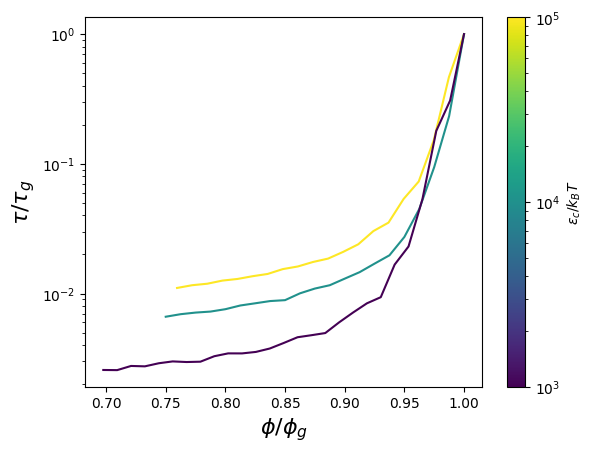

In [33]:
for temp in np.unique(temperatures_hist):
    mask = temperatures_hist == temp
    x = phis_hist[mask]
    y = taus_hist[mask]
    y[np.isnan(y)] = -np.inf
    y = y[np.argsort(x)]
    x = x[np.argsort(x)]


    x_g = x[np.argmax(y)]
    y_g = y[np.argmax(y)]
    x = x / x_g
    y = y / y_g
    y[y == -np.inf] = np.nan
    plt.plot(x, y, c=cmap(norm(softness[mask][0])))


    # phi = x
    # tau = y
    # m = np.isfinite(phi) & np.isfinite(tau) & (tau > 0)
    # phi, tau = phi[m], tau[m]
    # # sort by phi
    # order = np.argsort(phi)
    # phi, tau = phi[order], tau[order]
    # # choose a reference "glass" time (set this to what you want)
    # tau_g = 5e-1  # example
    # logtau = np.log10(tau)
    # logtau_g = np.log10(tau_g)
    # # find a crossing of tau_g
    # i = np.where((logtau[:-1] - logtau_g) * (logtau[1:] - logtau_g) <= 0)[0]
    # if len(i) == 0:
    #     raise ValueError("tau_g not bracketed by your data; pick a tau_g within the range of tau.")
    # i = i[0]
    # # interpolate phi_g at tau=tau_g (linear in log10(tau))
    # phi_g = np.interp(logtau_g, [logtau[i], logtau[i+1]], [phi[i], phi[i+1]])
    # x = phi / phi_g
    # y = np.log10(tau / tau_g)
    # plt.plot(x, y, "o-")

plt.yscale('log')

plt.xlabel(r'$\phi / \phi_g$', fontsize=16)
plt.ylabel(r'$\tau / \tau_g$', fontsize=16)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.unique(softness))
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\varepsilon_c / k_B T$')
